In [33]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import h5py
from scipy import io
from scipy import signal
import os
import glob

preparing data for training

(1024, 300, 1)


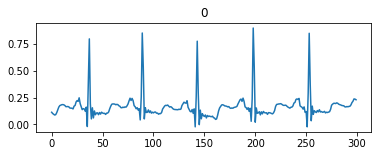

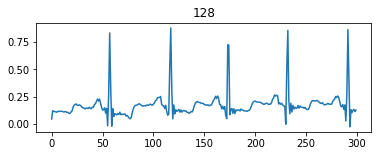

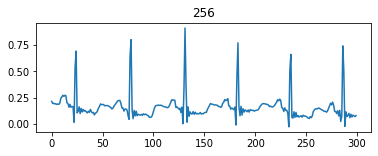

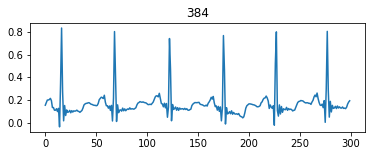

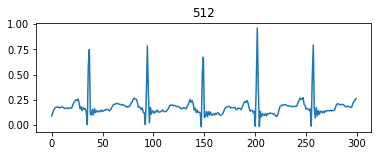

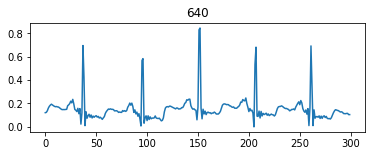

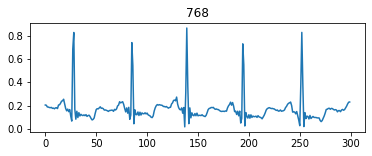

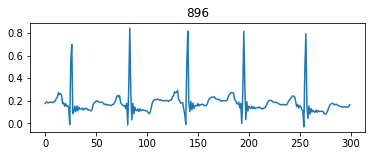

In [34]:
arr = []
for file in glob.glob('MLII/1 NSR/*.mat'):
    arr.append(file) 
arr = sorted(arr, key=lambda x:x[:])

l = 8 #283
w = 1500 #3600
st = 20
hwm = 128
stride = 5
data = []

for i in range(l):
    
    db = io.loadmat(arr[i]) 
    dummy = db['val'][0, :]
    dummy = np.append(dummy, dummy[0:w-st])
    
    for j in range(hwm):
        
        if j*st+w >= len(dummy):
            
            break;
        min = np.amin(dummy[j*st:j*st+w])
        max = np.amax(dummy[j*st:j*st+w])
        ddata = (dummy[j*st:j*st+w]-min)/(max-min)
        data.append(ddata)
data = signal.decimate(np.asarray(data).reshape(len(data), w, 1), stride, axis=1)
seq_in = np.copy(data)
print (seq_in.shape)  

for i in range(0, len(seq_in), hwm):
    
    plt.figure(figsize=(6, 2))
    plt.plot(seq_in[i, :, 0])
    plt.title(np.str(i))

GANLSTM for ECG data

In [35]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional, ConvLSTM2D, MaxPooling1D, Conv1D, Flatten, UpSampling1D, ZeroPadding1D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, RepeatVector
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l1_l2
import keras.backend as K
from keras.models import model_from_json

In [4]:
class GAN():
    def __init__(self, rows, channels):
        
        self.seq_length = rows
        self.channels = channels
        self.latent_dim = 100
        self.critic_loss = []
        self.gen_loss = []
        self.clip_value = 0.1
        self.n_critic = 5   
        optimizer_c = Adam(0.0002, 0.5)
        optimizer_g = Adam(0.0004, 0.5)
        
        self.critic = self.build_critic()
        self.critic.compile(loss='binary_crossentropy', optimizer=optimizer_c, metrics=['accuracy'])

        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)
        self.critic.trainable = False
        validity = self.critic(generated_seq)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    def build_critic(self):

        model = Sequential()            
        model.add(Conv1D(filters=64, kernel_size=6, strides=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))    
        model.add(Conv1D(filters=128, kernel_size=6, strides=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))         
        model.add(Flatten())         
        model.add(Dense(1, activation='sigmoid'))
        
        seq = Input(shape=(self.seq_length, self.channels))
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()      
        l = np.int(self.seq_length/4.0)
        model.add(Dense(l*128, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((l, 128)))
        model.add(UpSampling1D(2))
        model.add(Conv1D(128, kernel_size=6, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling1D(2))
        model.add(Conv1D(64, kernel_size=6, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Conv1D(self.channels, kernel_size=6, padding='same'))
        model.add(Activation('sigmoid'))        
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=64, sample_interval=10):

        X_train = seq_in      
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            for _ in range(self.n_critic):
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_seqs = X_train[idx]
                
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim)) 
                gen_seqs = self.generator.predict(noise)            

                d_loss_real = self.critic.train_on_batch(real_seqs, real)
                d_loss_fake = self.critic.train_on_batch(gen_seqs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                for l in self.critic.layers:
                    
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            g_loss = self.combined.train_on_batch(noise, real)

            if epoch % sample_interval == 0:
                
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
              self.critic_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        self.plot_loss()            
            
    def plot_loss(self):
        
        plt.plot(self.critic_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['critic', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()            

In [5]:
gan = GAN(rows=seq_in.shape[1], channels=seq_in.shape[2])    
gan.train(epochs=10000, batch_size=64, sample_interval=100)

W0912 21:19:14.546311 140295589394240 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 21:19:14.548576 140295589394240 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 21:19:14.553511 140295589394240 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0912 21:19:14.671065 140295589394240 deprecation_wrapper.py:119] From /home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default 

0 [D loss: 0.685664] [G loss: 0.690910]


/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.571275] [G loss: 0.713396]
200 [D loss: 0.594205] [G loss: 0.778941]
300 [D loss: 0.487202] [G loss: 1.004652]
400 [D loss: 0.421831] [G loss: 0.936607]
500 [D loss: 0.477029] [G loss: 1.030616]
600 [D loss: 0.465382] [G loss: 1.035449]
700 [D loss: 0.512354] [G loss: 1.089081]
800 [D loss: 0.531106] [G loss: 0.984568]
900 [D loss: 0.519847] [G loss: 0.989501]
1000 [D loss: 0.501518] [G loss: 1.002812]
1100 [D loss: 0.431167] [G loss: 1.041291]
1200 [D loss: 0.506712] [G loss: 0.990489]
1300 [D loss: 0.530315] [G loss: 0.965275]
1400 [D loss: 0.527851] [G loss: 1.005075]
1500 [D loss: 0.484988] [G loss: 1.029306]
1600 [D loss: 0.462787] [G loss: 1.084490]
1700 [D loss: 0.527020] [G loss: 0.973825]
1800 [D loss: 0.527656] [G loss: 0.932954]
1900 [D loss: 0.532042] [G loss: 0.970969]
2000 [D loss: 0.493330] [G loss: 0.970866]
2100 [D loss: 0.525575] [G loss: 0.898783]
2200 [D loss: 0.563054] [G loss: 0.897495]
2300 [D loss: 0.535626] [G loss: 0.941122]
2400 [D loss: 0.5333

generate synthetic ecg

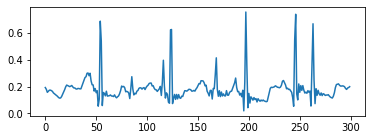

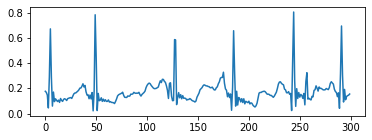

In [36]:
noise = np.random.normal(0, 1, (2, gan.latent_dim))
gen_seqs = gan.generator.predict(noise).reshape(2, gan.seq_length)
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[0])
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[1])

In [37]:
model = gan.generator
model_json = model.to_json()
with open("gan.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("gan.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
json_file = open('gan.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("gan.h5")
print("Loaded model from disk")

Loaded model from disk


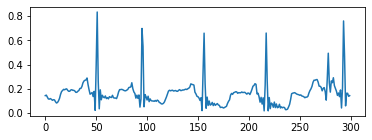

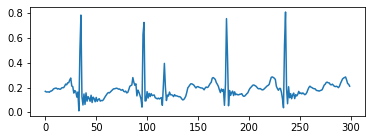

In [39]:
noise = np.random.normal(0, 1, (2, gan.latent_dim))
gen_seqs = loaded_model.predict(noise).reshape(2, gan.seq_length)
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[0])
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[1])